# Joe's cool code

In [394]:
# Import General Libs
import pandas as pd
import os
import scipy as sp
import scipy.signal as sps
from scipy import integrate
from scipy import diff
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

# Import project libs
import Data.DataWrangle as DW

In [395]:
#Data setup
cleanData = DW.read_into_MC_format(with_pct_change=True)
# cleanData

## Intergration Work

In [396]:
# def add_Rolling_ID_Values(df:pd.DataFrame,data_col,rollNum):
#     result = add_rolling_integrate(df,data_col,rollNum)
#     result = add_rolling_derivatives(result,data_col,rollNum)
#     return result
def add_rolling_integrate(df:pd.DataFrame,data_col,rollNum):
    data = df[data_col]
    integral = data.rolling(rollNum).apply(integrate.trapz)
    integral = integral.rename(f'{data_col}_integral')
    return pd.concat([df,integral],axis=1)

# def add_rolling_derivatives(df:pd.DataFrame,data_col,rollNum):
#     data = df[data_col]
#     derivative = data.rolling(rollNum).apply(diff)
#     derivative = derivative.rename(f'{data_col}_derivative')
#     return pd.concat([df,derivative],axis=1)

In [397]:
window = 2
VIX_PID_Data = add_rolling_integrate(cleanData['VIX'],'close',window)
VIX_PID_Data = add_rolling_integrate(VIX_PID_Data,'pct_change',window)
VIX_PID_Data = DW.tag_columns(VIX_PID_Data,'VIX')
# VIX_PID_Data.dropna()

In [398]:
SPY_PID_Data = add_rolling_integrate(cleanData['SPY'],'close',window)
SPY_PID_Data = add_rolling_integrate(SPY_PID_Data,'pct_change',window)
SPY_PID_Data = DW.tag_columns(SPY_PID_Data,'SPY')
# SPY_PID_Data

In [399]:
graphing_data = pd.concat([VIX_PID_Data,SPY_PID_Data],axis=1)
graphing_data


,VIX_close,VIX_pct_change,VIX_close_integral,VIX_pct_change_integral,SPY_close,SPY_pct_change,SPY_close_integral,SPY_pct_change_integral
timestamp,,,,,,,,
1990-01-02,17.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,18.19,0.055104,17.715,NaN,NaN,NaN,NaN,NaN
1990-01-04,19.22,0.056625,18.705,0.055864,NaN,NaN,NaN,NaN
1990-01-05,20.11,0.046306,19.665,0.051465,NaN,NaN,NaN,NaN
1990-01-08,20.26,0.007459,20.185,0.026882,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-03-24,21.67,-0.080611,22.620,-0.026574,450.48,0.015052,447.140,0.001087
2022-03-25,20.81,-0.039686,21.240,-0.060149,452.69,0.004906,451.585,0.009979
2022-03-28,19.63,-0.056704,20.220,-0.048195,455.91,0.007113,454.300,0.006009


<AxesSubplot:xlabel='timestamp'>

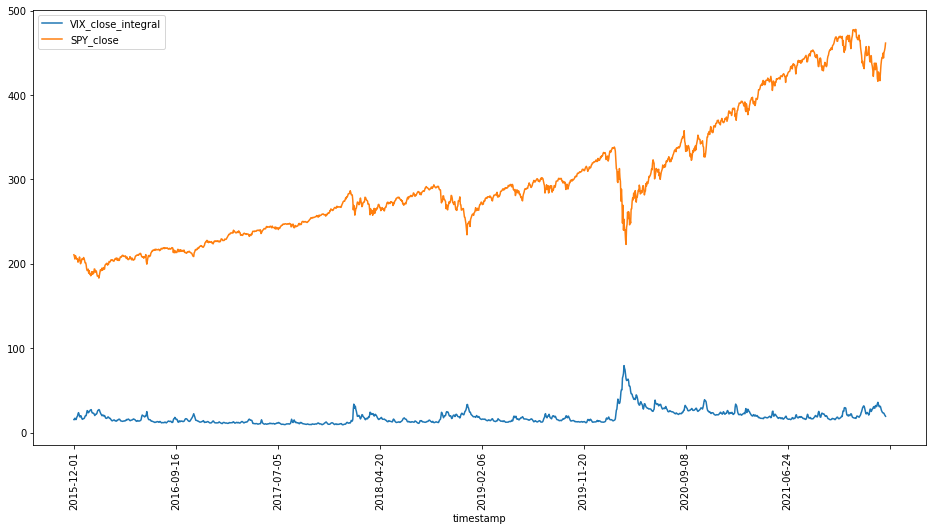

In [400]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['VIX_close_integral','SPY_close']].dropna().plot(rot=90,figsize=(16,8))

<AxesSubplot:xlabel='timestamp'>

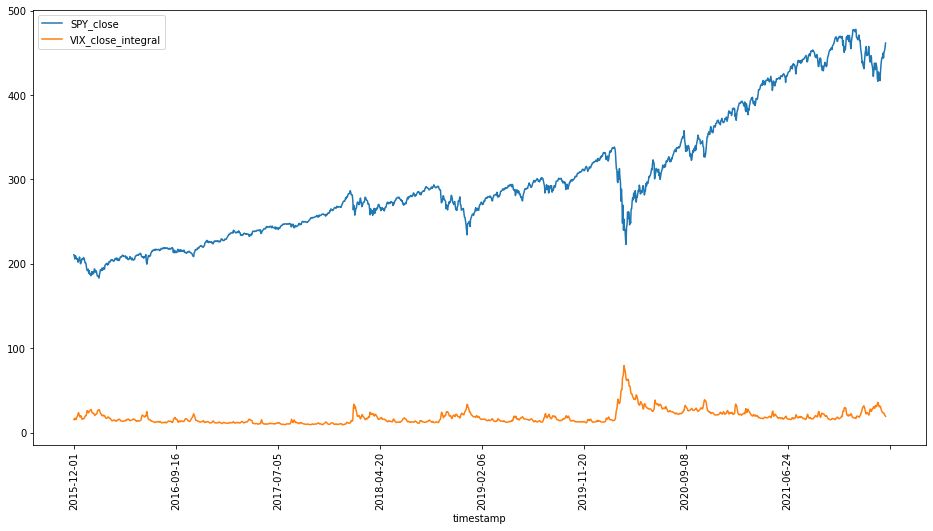

In [401]:
scaled = graphing_data
# scaled['VIX_close_integral'] = graphing_data['VIX_close_integral']+graphing_data['SPY_close'].dropna().iloc[0]
scaled[['SPY_close','VIX_close_integral']].dropna().plot(rot=90,figsize=(16,8))

## SPY and VIX Peak analysis

In [408]:
cleanData
Peak_data = pd.concat([
    DW.tag_columns(cleanData['VIX'],'VIX'), 
    DW.tag_columns(cleanData['SPY'],'SPY').shift(-1)]
    ,join='inner',axis=1).dropna()
Peak_data

,VIX_close,VIX_pct_change,SPY_close,SPY_pct_change
timestamp,,,,
2015-12-01,14.67,-0.090515,208.54,-0.010158
2015-12-02,15.91,0.084526,205.58,-0.014194
2015-12-03,18.11,0.138278,209.66,0.019846
2015-12-04,14.81,-0.182220,208.27,-0.006630
2015-12-07,15.84,0.069548,206.99,-0.006146
...,...,...,...,...
2022-03-23,23.57,0.027463,450.48,0.015052
2022-03-24,21.67,-0.080611,452.69,0.004906
2022-03-25,20.81,-0.039686,455.91,0.007113


In [403]:
df = Peak_data['VIX_close']
stds=1
roll=5

rollMean = df.rolling(window=roll).mean()
rollSTD = df.rolling(window=roll).std()
thresh = (rollMean+rollSTD*stds)
thresh[:roll]=[0]*roll
np_thresh = np.array(thresh)
# zipper = list(zip([0]*len(thresh),thresh))
peakArray = sps.find_peaks(df,height=np_thresh)

In [404]:
def peaks_std(df:pd.DataFrame, stds,roll):
    rollMean = df.rolling(window=roll).mean()
    rollSTD = df.rolling(window=roll).std()
    thresh = (rollMean+rollSTD*stds).to_list()
    thresh[:roll]=[0]*roll
    np_thresh = np.array(thresh)
    # zipper = list(zip([0]*len(thresh),thresh))
    peakArray = sps.find_peaks(df,height=np_thresh)
    return df[peakArray[0]]

peaks = peaks_std(Peak_data['VIX_close'],stds=1.5,roll=60)
# peaks

In [405]:
def plot_with_marks(data,markdata,on_data_line=True):
    plt.plot(data.index,data.to_list())
    if on_data_line : plt.plot(markdata.index,data.loc[markdata.index],"x")
    else : plt.plot(markdata.index,markdata.tolist(),"x")
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.set_size_inches(12,8)
    #Axis labels
    #Legend
    #style
    return plt.show()

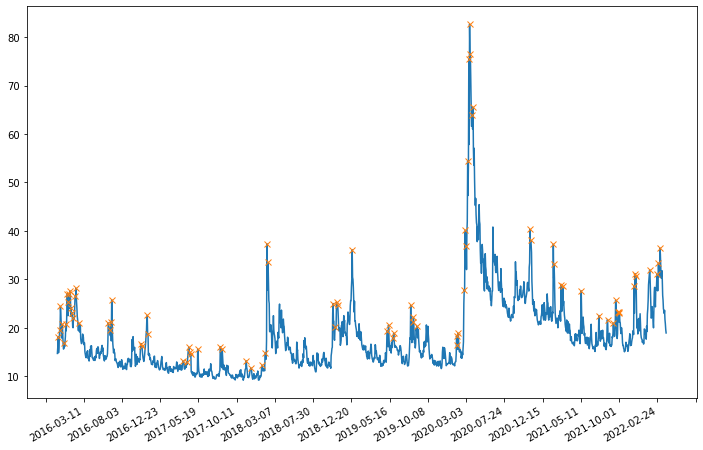

In [406]:
plot_with_marks(Peak_data['VIX_close'],peaks)

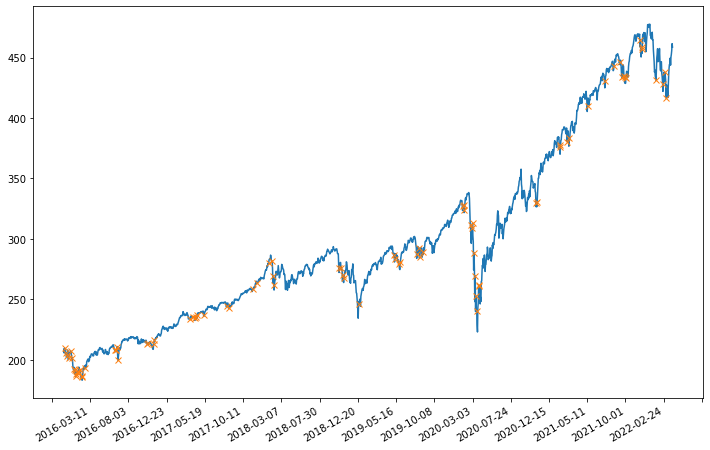

In [407]:
plot_with_marks(Peak_data['SPY_close'],peaks)